In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [101]:
DATA_FOLDER = "Data/Runs300"

EXPERIMENT_NAMES = \
{
	"EX1": "EX1. Baseline",
	"EX2": "EX2. WithoutAnchoring",
	"EX3": "EX3. WithAnchoring",
}

REPORTERS = \
{
	"num_believers": "count turtles with [state = \"B\"]"
}

invert_dict = lambda x: { value: key for key, value in x.items() }

def experiment_file(experiment_label):
	return f'{DATA_FOLDER}/InformationDiffusionProcesModel {EXPERIMENT_NAMES[experiment_label]}-table.csv'

def load_experiment(experiment_label):
	file_name = experiment_file(experiment_label)

	# Read CSV for file, skip 6 rows as they are meta data
	df = pd.read_csv(file_name, skiprows=6)
	df = df.rename(columns=invert_dict(REPORTERS))
	df = df.sort_values(by='[step]')

	return df

In [102]:
def split_df(df, key):
	"""Split the data frame by the given key, returns a list of data frames"""
	df_grouped = df.groupby(key)
	return [ df_grouped.get_group(x) for x in df_grouped.groups ]

def calculate_stats(df):
	"""Calculates our derived stats for the given run data frame"""
	num_believers = df['num_believers']
	initial_agents = df['number-of-agents'].iloc[0]
	initial_believers = num_believers.iloc[0]

	hoax_persistence = num_believers.iloc[-10:].mean() / initial_agents
	hoax_spread = (num_believers.max() - initial_believers) / num_believers.idxmax()

	return { 'hoax_persistence': hoax_persistence, 'hoax_spread': hoax_spread }



In [103]:
def process_experiment(experiment_label, group_key = None):
	df = load_experiment(experiment_label)

	if group_key is not None:
		variations = split_df(df, group_key)
	else:
		variations = [ df ]

	result = { }

	for df in variations:
		runs = split_df(df, '[run number]')
		
		stats = pd.DataFrame([ calculate_stats(df) for df in runs ])

		variation_key = df[group_key].iloc[0] if group_key is not None else None
		result[variation_key] = stats

	#return { key: stats[key].mean() for key in stats.columns }
	return result

In [104]:
ex1 = process_experiment('EX1')
ex2 = process_experiment('EX2', 'max-susceptibility-to-verify')
ex3 = process_experiment('EX3', 'max-susceptibility-to-verify')

ex1, ex2, ex3

({None:      hoax_persistence  hoax_spread
  0              0.0000    13.069767
  1              0.0000     9.241935
  2              0.0000     0.031946
  3              0.0070    10.843137
  4              0.0095    39.071429
  ..                ...          ...
  295            0.0628     0.006317
  296            0.0265     0.006346
  297            0.0489     0.005766
  298            0.0016     0.006154
  299            0.0000     0.005329
  
  [300 rows x 2 columns]},
 {0.1:      hoax_persistence  hoax_spread
  0              0.4838     0.428337
  1              0.5645     1.079832
  2              0.5114     2.366812
  3              0.5376     2.626794
  4              0.5721     1.014953
  ..                ...          ...
  295            0.4657     0.005601
  296            0.4916     0.005974
  297            0.5221     0.006166
  298            0.5303     0.005602
  299            0.5761     0.006063
  
  [300 rows x 2 columns],
  0.2:      hoax_persistence  hoax_spread


[0.017656666666666668, 0.5039676666666666, 0.6349656666666667]


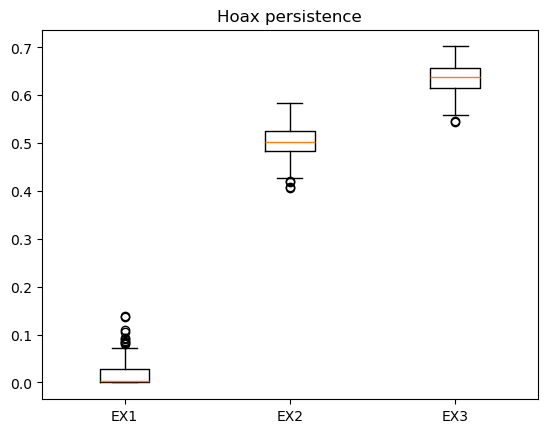

In [105]:
reference_s_max_verify = 0.2
reference_results = [ ex1[None], ex2[reference_s_max_verify], ex3[reference_s_max_verify] ]

plt.title('Hoax persistence')

fig = plt.boxplot(
	x=[ df['hoax_persistence'] for df in reference_results ],
	labels=[ 'EX1', 'EX2', 'EX3'],
)

print([ result['hoax_persistence'].mean() for result in reference_results ])

[0.41291968031421683, 0.0038830688391458335, 0.004784961101386707]


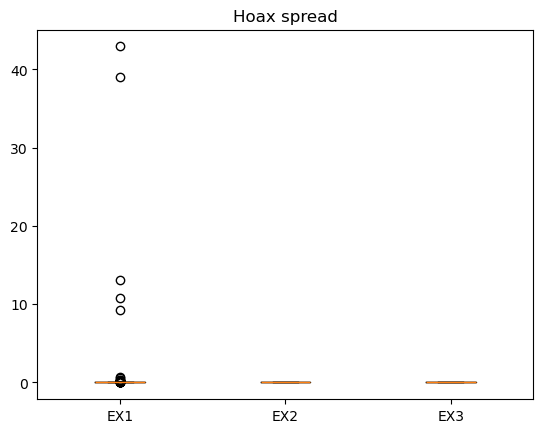

In [106]:
plt.title('Hoax spread')

fig = plt.boxplot(
	x=[ df['hoax_spread'] for df in reference_results ],
	labels=[ 'EX1', 'EX2', 'EX3'],
)

print([ result['hoax_spread'].mean() for result in reference_results ])

({0.1: 0.5380886666666667,
  0.2: 0.5039676666666666,
  0.3: 0.4660520000000001,
  0.4: 0.4356626666666667,
  0.5: 0.400717,
  0.6: 0.3788303333333333,
  0.7: 0.3544623333333334,
  0.8: 0.33259666666666665,
  0.9: 0.31991966666666666,
  1.0: 0.314671},
 {0.1: 0.680871,
  0.2: 0.6349656666666667,
  0.3: 0.5898916666666667,
  0.4: 0.5463956666666667,
  0.5: 0.497495,
  0.6: 0.4501843333333333,
  0.7: 0.40042400000000006,
  0.8: 0.3488763333333333,
  0.9: 0.29015966666666665,
  1.0: 0.240813})

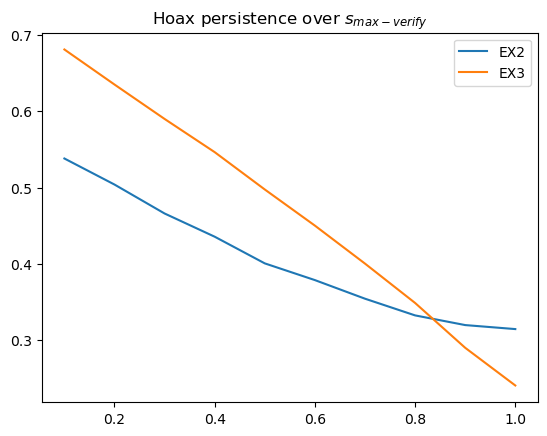

In [107]:


persistence_over_s_max = lambda result: { key: df['hoax_persistence'].mean() for key, df in result.items() }

data_ex2 = persistence_over_s_max(ex2)
data_ex3 = persistence_over_s_max(ex3)

plt.title('Hoax persistence over $s_{max-verify}$')
plt.plot(data_ex2.keys(), data_ex2.values(), label="EX2")
plt.plot(data_ex3.keys(), data_ex3.values(), label="EX3")
plt.legend()

data_ex2, data_ex3